In [136]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os

sns.set_style('darkgrid')
plt.style.use("fivethirtyeight")
pio.templates.default = "plotly_dark"

In [137]:
daily_path, weekly_path, monthly_path = [], [], []

for dirname, _, filenames in os.walk(r'C:\Users\Vedant\Desktop\Portfolio\Stock Price Forecasting\Dataset'):
    for filename in filenames:
        if filename.split('_')[1] == 'daily.csv':
            daily_path.append(os.path.join(dirname, filename))
        elif filename.split('_')[1] == 'weekly.csv':
            weekly_path.append(os.path.join(dirname, filename))
        else:
            monthly_path.append(os.path.join(dirname, filename))


In [138]:
# Create dfs containing data after a given date
def create_df_list(path=daily_path, date='2021-01-01'):
    df_list = []
    companies = ['GOOG', 'AMZN', 'AAPL', 'META', 'NFLX']
    for i, path in enumerate(daily_path):
        df = pd.read_csv(path)
        df = df[df['Date'] >= date] 
        df['Ticker'] = companies[i]
        df_list.append(df)
    return df_list

df_list = create_df_list()
goog_df, amzn_df, aapl_df, meta_df, nflx_df = df_list

In [139]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1049 entries, 4122 to 5170
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1049 non-null   object 
 1   Open       1049 non-null   float64
 2   High       1049 non-null   float64
 3   Low        1049 non-null   float64
 4   Close      1049 non-null   float64
 5   Adj Close  1049 non-null   int64  
 6   Volume     1049 non-null   float64
 7   Ticker     1049 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 73.8+ KB


In [140]:
aapl_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64

In [141]:
aapl_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1049.000000,1049.000000,1049.000000,1049.000000,1.049000e+03,1049.000000
mean,133.393878,134.912502,132.030674,133.475465,2.453786e+07,133.475465
std,28.064927,28.208854,27.864094,28.016096,1.037889e+07,28.016096
min,84.826708,86.240136,83.151228,83.191086,6.809800e+06,83.191086
25%,111.537238,113.257547,110.327878,111.785347,1.762100e+07,111.785347
50%,132.533790,133.718033,130.930551,132.733078,2.210910e+07,132.733078
75%,147.912519,149.090296,146.673000,147.948410,2.838800e+07,147.948410
max,204.500000,208.699997,204.259995,207.710007,9.779860e+07,207.710007


**Candlestick charts**
A candlestick chart gives a clear picture of the increase and decrease in stock prices, so let’s visualize a candlestick chart of the data before moving further

In [142]:
# Create candlestick chart

def create_candlestick(df, name):
    figure = go.Figure(data=[go.Candlestick(x=df["Date"],
                                        open=df["Open"], 
                                        high=df["High"],
                                        low=df["Low"], 
                                        close=df["Close"])])
    figure.update_layout(title = f"{name} Stock Prices since 2024", 
                         xaxis_rangeslider_visible=False)
    figure.show()
    
create_candlestick(aapl_df, "Apple")
create_candlestick(nflx_df, "Netflix")
create_candlestick(meta_df, "Meta")
create_candlestick(goog_df, "Google")
create_candlestick(amzn_df, "Amazon")


**Faceted area charts**
Now let’s look at the faceted area chart, which makes it easy to compare the performance of different companies and identify similarities or differences in their stock price movements.

In [143]:
# Create faceted area charts
combined_df = pd.concat(df_list, ignore_index=True)
fig = px.area(combined_df, x='Date', y='Close', color='Ticker',facet_col='Ticker',
              labels={'Date':'Date', 'Close':'Closing Price', 'Ticker':'Company'},
              title='Stock Prices for Google, Amazon, Apple, Meta, and Netflix')
fig.show()

In [144]:
# Create moving average plots
combined_df['MA20'] = combined_df.groupby('Ticker')['Close'].rolling(window=20).mean().reset_index(drop=True)
combined_df['MA40'] = combined_df.groupby('Ticker')['Close'].rolling(window=40).mean().reset_index(drop=True)

for comp, group in combined_df.groupby('Ticker'):
    fig = px.line(group, x='Date', y=['Close', 'MA20', 'MA40'], 
                  title=f"Moving Averages for {comp}")
    fig.show()

When the MA20 crosses above the MA40, it is considered a bullish signal indicating that the stock price will continue to rise. Conversely, when the MA20 crosses below the MA40, it is a bearish signal that the stock price will continue falling.

In [145]:
# Create volatility plots
combined_df['Volatility'] = combined_df.groupby('Ticker')['Close'].pct_change().rolling(window=10).std().reset_index(drop=True)

fig = px.area(combined_df, x='Date', y='Volatility', color='Ticker',facet_col='Ticker',
              labels={'Date':'Date', 'Volatility':'Volatility', 'Ticker':'Company'},
              title='Volatility for Google, Amazon, Apple, Meta, and Netflix stocks')
fig.show()

High volatility indicates that the stock experiences large and frequent price movements, while low volatility indicates that the stock experiences smaller or less frequent price movements. From the above plot it can be seen that Netflix and Meta has the highest volatility and the value of the stock price for these companies fluctuates a lot. Investing in these 2 companies can be a little risky compared to the other 3.

**Applying LSTM Model**

In [146]:
# Import required modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [147]:
nflx_df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
4686,2021-01-04,539.000000,540.799988,515.090027,522.859985,4444400,522.859985,NFLX
4687,2021-01-05,521.549988,526.780029,515.890015,520.799988,3133900,520.799988,NFLX
4688,2021-01-06,511.970001,513.099976,499.500000,500.489990,5346200,500.489990,NFLX
4689,2021-01-07,508.279999,516.440002,506.420013,508.890015,3686400,508.890015,NFLX
4690,2021-01-08,511.309998,513.239990,504.510010,510.399994,2973900,510.399994,NFLX
...,...,...,...,...,...,...,...,...
5730,2025-03-03,983.000000,994.929993,964.809998,973.700012,3907400,973.700012,NFLX
5731,2025-03-04,971.609985,986.309998,948.210022,972.580017,4392800,972.580017,NFLX
5732,2025-03-05,973.619995,995.599976,969.479980,990.919983,3807900,990.919983,NFLX
5733,2025-03-06,972.989990,973.690002,899.000000,906.359985,7852600,906.359985,NFLX


Shape of x_train: (889, 100, 1)
Shape of y_train: (889,)
Epoch 1/50
56/56 [==============================] - 18s 109ms/step - loss: 0.0168
Epoch 2/50
56/56 [==============================] - 6s 111ms/step - loss: 0.0040
Epoch 3/50
56/56 [==============================] - 6s 113ms/step - loss: 0.0035
Epoch 4/50
56/56 [==============================] - 6s 110ms/step - loss: 0.0037
Epoch 5/50
56/56 [==============================] - 6s 112ms/step - loss: 0.0034
Epoch 6/50
56/56 [==============================] - 6s 109ms/step - loss: 0.0032
Epoch 7/50
56/56 [==============================] - 6s 111ms/step - loss: 0.0029
Epoch 8/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0030
Epoch 9/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0028
Epoch 10/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0024
Epoch 11/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0026
Epoch 12/50
56/56 [==============================

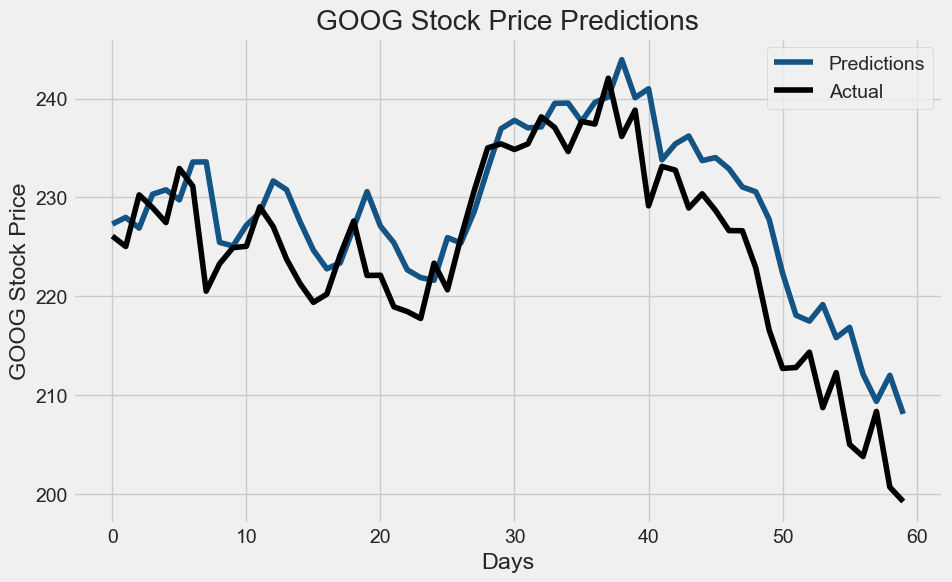

Shape of x_train: (889, 100, 1)
Shape of y_train: (889,)
Epoch 1/50
56/56 [==============================] - 12s 88ms/step - loss: 0.0210
Epoch 2/50
56/56 [==============================] - 5s 97ms/step - loss: 0.0040
Epoch 3/50
56/56 [==============================] - 6s 112ms/step - loss: 0.0039
Epoch 4/50
56/56 [==============================] - 6s 114ms/step - loss: 0.0037
Epoch 5/50
56/56 [==============================] - 6s 111ms/step - loss: 0.0033
Epoch 6/50
56/56 [==============================] - 6s 109ms/step - loss: 0.0028
Epoch 7/50
56/56 [==============================] - 6s 112ms/step - loss: 0.0032
Epoch 8/50
56/56 [==============================] - 6s 109ms/step - loss: 0.0026
Epoch 9/50
56/56 [==============================] - 6s 109ms/step - loss: 0.0024
Epoch 10/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0021
Epoch 11/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0023
Epoch 12/50
56/56 [==============================] 

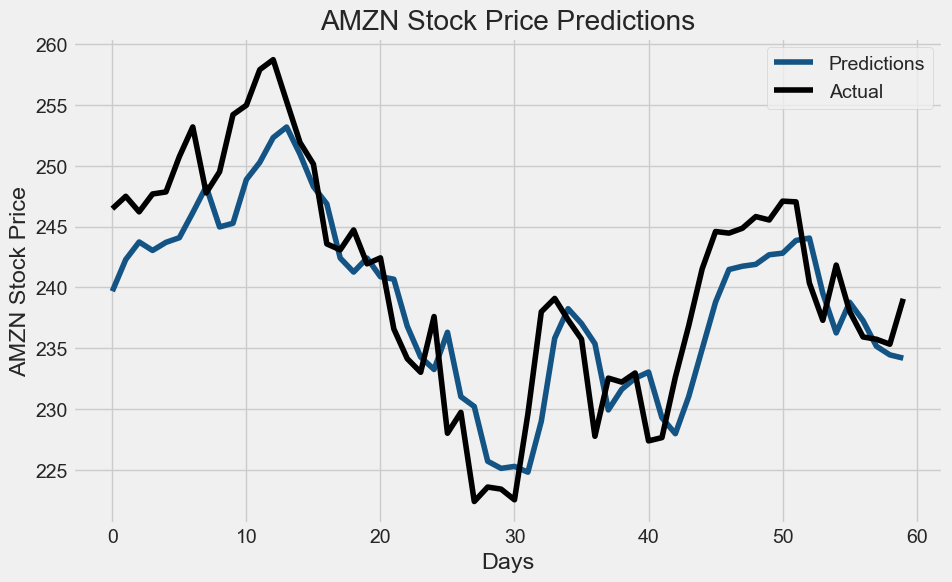

Shape of x_train: (889, 100, 1)
Shape of y_train: (889,)
Epoch 1/50
56/56 [==============================] - 15s 109ms/step - loss: 0.0211
Epoch 2/50
56/56 [==============================] - 6s 110ms/step - loss: 0.0040
Epoch 3/50
56/56 [==============================] - 6s 111ms/step - loss: 0.0041
Epoch 4/50
56/56 [==============================] - 6s 109ms/step - loss: 0.0032
Epoch 5/50
56/56 [==============================] - 6s 110ms/step - loss: 0.0032
Epoch 6/50
56/56 [==============================] - 6s 112ms/step - loss: 0.0029
Epoch 7/50
56/56 [==============================] - 6s 113ms/step - loss: 0.0027
Epoch 8/50
56/56 [==============================] - 6s 112ms/step - loss: 0.0027
Epoch 9/50
56/56 [==============================] - 6s 110ms/step - loss: 0.0025
Epoch 10/50
56/56 [==============================] - 6s 111ms/step - loss: 0.0023
Epoch 11/50
56/56 [==============================] - 7s 120ms/step - loss: 0.0023
Epoch 12/50
56/56 [==============================

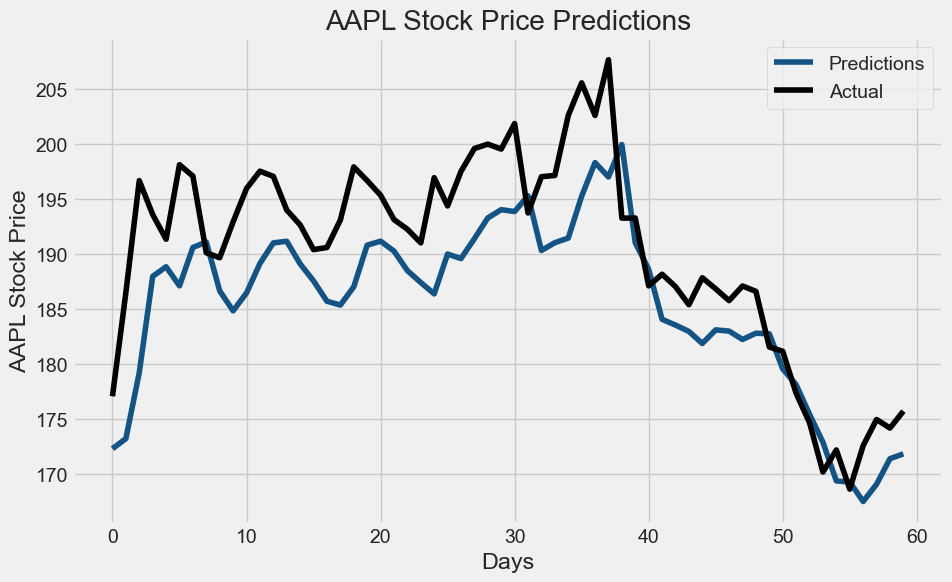

Shape of x_train: (889, 100, 1)
Shape of y_train: (889,)
Epoch 1/50
56/56 [==============================] - 15s 108ms/step - loss: 0.0157
Epoch 2/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0022
Epoch 3/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0022
Epoch 4/50
56/56 [==============================] - 6s 109ms/step - loss: 0.0019
Epoch 5/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0022
Epoch 6/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0021
Epoch 7/50
56/56 [==============================] - 6s 111ms/step - loss: 0.0017
Epoch 8/50
56/56 [==============================] - 6s 112ms/step - loss: 0.0017
Epoch 9/50
56/56 [==============================] - 6s 111ms/step - loss: 0.0015
Epoch 10/50
56/56 [==============================] - 6s 108ms/step - loss: 0.0013
Epoch 11/50
56/56 [==============================] - 6s 110ms/step - loss: 0.0013
Epoch 12/50
56/56 [==============================

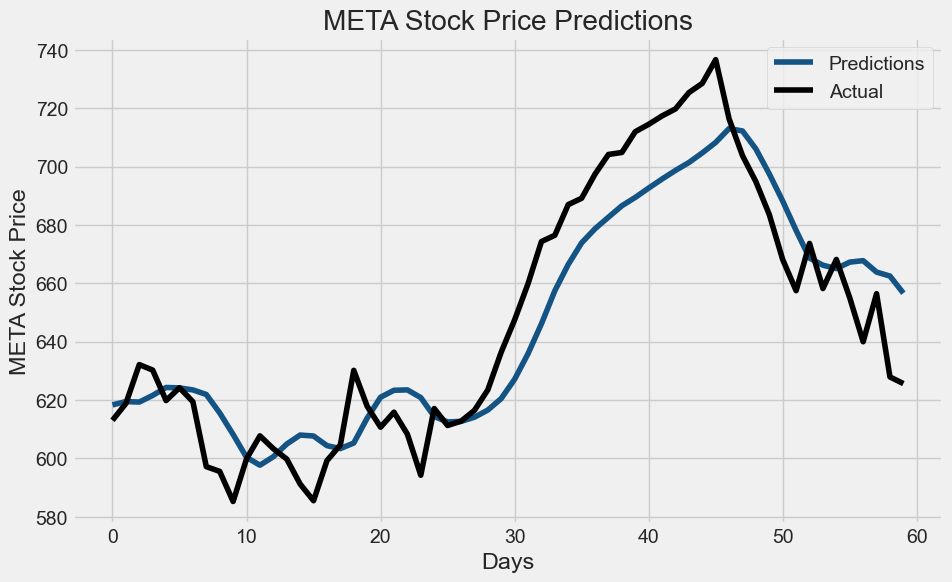

Shape of x_train: (889, 100, 1)
Shape of y_train: (889,)
Epoch 1/50
56/56 [==============================] - 13s 96ms/step - loss: 0.0118
Epoch 2/50
56/56 [==============================] - 5s 88ms/step - loss: 0.0025
Epoch 3/50
56/56 [==============================] - 5s 86ms/step - loss: 0.0021
Epoch 4/50
56/56 [==============================] - 5s 84ms/step - loss: 0.0020
Epoch 5/50
56/56 [==============================] - 5s 83ms/step - loss: 0.0017
Epoch 6/50
56/56 [==============================] - 5s 86ms/step - loss: 0.0022
Epoch 7/50
56/56 [==============================] - 5s 83ms/step - loss: 0.0017
Epoch 8/50
56/56 [==============================] - 5s 83ms/step - loss: 0.0018
Epoch 9/50
56/56 [==============================] - 5s 82ms/step - loss: 0.0016
Epoch 10/50
56/56 [==============================] - 5s 82ms/step - loss: 0.0017
Epoch 11/50
56/56 [==============================] - 5s 85ms/step - loss: 0.0015
Epoch 12/50
56/56 [==============================] - 5s 87ms

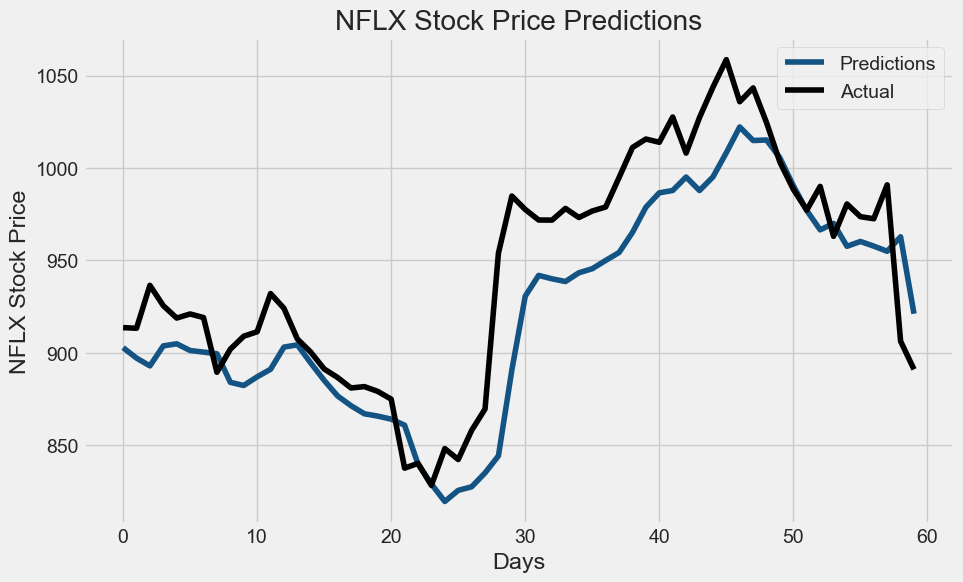

In [148]:
for df in df_list:
    # Extract ticker symbol for labeling
    ticker = df["Ticker"].iloc[0]

    # Train data excluding roughly last 3 months (~60 trading days)
    train_data = df.iloc[:-60, 4].values

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data.reshape(-1, 1))

    # Create separate lists for features and labels
    x_train, y_train = [], []

    # Store data for previous 100 days in x_train and the outcomes in y_train
    for i in range(100, len(scaled_data)):
        x_train.append(scaled_data[i-100:i, 0])
        y_train.append(scaled_data[i, 0])

    # Convert to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data for LSTM or similar models
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    print(f"Shape of x_train: {x_train.shape}\nShape of y_train: {y_train.shape}")

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model (adjust epochs/batch size as needed)
    model.fit(x_train, y_train, epochs=50, batch_size=16)

    # Prepare test data (last ~3 months + previous 100 days)
    test_data = df.iloc[-160:, 4].values
    test_data_scaled = scaler.transform(test_data.reshape(-1, 1))

    x_test = []
    for i in range(100, len(test_data_scaled)):
        x_test.append(test_data_scaled[i-100:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    y_test = df.iloc[-60:, 4].values

    print(f"Shape of x_test: {x_test.shape}\nShape of y_test: {y_test.shape}")

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    
    print(f"RMSE for {df['Ticker'].iloc[0]}: {rmse}")

    # Plot actual vs predicted values clearly labeled with ticker symbol
    ticker = df["Ticker"].iloc[0]  # Extract Ticker symbol from DataFrame

    plt.figure(figsize=(10,6))
    
    plt.plot(predictions, color='#135485', label="Predictions")
    plt.plot(y_test, color='black', label="Actual")
    
    plt.xlabel('Days')
    
    plt.ylabel(f'{ticker} Stock Price')
    
    plt.title(f'{ticker} Stock Price Predictions')
    
    plt.legend()
    
    plt.show()